# Implementing Modern CNN Architectures and Image Preprocessing

Last week, we discussed CNNs and some popular architectures like LeNet (1998), AlexNet (2012) and VGGNet (2014). This week, we expand to some newer models with GoogLeNet (2014), ResNets (2015), and beyond. Details about this will be in the lecture notes.

Next, and the subject of most of this notebook, is running some experiments with some CNNs and diving a bit deeper into preprocessing image datasets. Much of the pipeline we develop could be applied to other types of datasets as well, but the specific types of preprocessing we would want to run for audio or video, for example, might be different.

## Preliminaries

First, let's import all the things we need, and check our computational resources.

In [1]:
# import lots of things!
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib

In [2]:
# check if a GPU is activated and print what kind it is
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print("Num GPUs Available: ", numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)
    
# print the version of tensorflow
print(tf.__version__)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5
2.1.0


Depending on what hardware you're using and your setup on the software side, you may or may not see the name of a GPU when you run this code block.

## CNN Architectures

For testing, we will use two modern architectures--AlexNet and a small version of VGGNet and one older net, LeNet-5. Below we simply copy the code for each net from last week's notes.

In [3]:
# write a class for LeNet (LeCun et. al. 1998)
class LeNet:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

In [4]:
# write a class for AlexNet (Krizhevsky et. al. 2012)
class AlexNet:
    def build(height, width, depth, classes, lambda2 = 0.0002):
        # create the model and name it AlexNet
        model = Sequential(name = 'AlexNet')
        
        # convolutional layer with 96 11x11 feature maps with stride 4x4
        model.add(Conv2D(96, (11, 11), strides = (4, 4), input_shape = (height, width, depth),
                         padding='same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # 3x3 max pooling layer with stride 2x2
        model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
        model.add(Dropout(0.25))
        
        # convolutional layer with 256 5x5 feature maps with stride 1x1
        model.add(Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # 3x3 max pooling layer with stride 2x2
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # convolutional layer with 384 3x3 feature maps with stride 1x1
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # convolutional layer with 384 3x3 feature maps with stride 1x1
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # convolutional layer with 256 3x3 feature maps with stride 1x1
        model.add(Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # 3x3 max pooling layer with stride 2x2
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # flatten the square array activations to one vector
        model.add(Flatten())
        
        # fully-connected layer
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # fully-connected layer
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fully-connected layer with softmax classifier
        model.add(Dense(classes, kernel_regularizer = l2(lambda2)))
        model.add(Activation('softmax'))
        
        # return the model
        return model

In [5]:
# create a class for a mini version of VGGNet (Simonyan and Zisserman, 2015)
class MiniVGGNet:
    def build(height, width, depth, classes):
        # create the model and name it MiniVGGNet
        model = Sequential(name = 'MiniVGGNet')
                
        # convolutional layer with 32 3x3 feature maps
        model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # convolutional layer with 32 3x3 feature maps
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # 2x2 max pooling layer with stride 2x2
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # convolutional layer with 64 3x3 feature maps
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # convolutional layer with 64 3x3 feature maps
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # 2x2 max pooling layer with stride 2x2
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # flatten the activations from a square to a vector
        model.add(Flatten())
        
        # fully-connected layer
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fully-connected layer with softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

## Implementing an Efficient Preprocessing and Data Loading Method

In many practical classification problems, it's ideal to store a dataset made up of multiple files sorted into a folder hierarchy where each folder corresponds to one of the data classes. So, let's suppose this is the situation and find an efficient way to preprocess the data and pull it into Python memory.

In [14]:
# Write a class for data preprocessing and loading (This is for images, but a similar procedure
# is a good idea for any dataset stored in separate files)
import cv2
import os
import numpy as np
from imutils import paths
from random import randint

# image preprocessor
class SimpleImagePreprocessor:
    def __init__(self, width, height, cWidth = 0, cHeight = 0, cropAugment = 1, interpolation = cv2.INTER_AREA):
        # store target image width, height, and interpolation method for resizing
        self.width = width
        self.height = height
        self.cWidth = cWidth
        self.cHeight = cHeight
        self.interpolation = interpolation
        self.cropAugment = cropAugment
        self.translationAugment = 0
        
    def resize(self, image):
        # resize to a fixed size ignoring aspect ratio
        return [cv2.resize(image, (self.width, self.height), interpolation = self.interpolation)]
    
    # randomly crop an image nAugment times and return each
    def randomCrop(self, image):
        images = []
        
        # iterate from 0 to nAugment
        for counter in np.arange(0, self.cropAugment):
            # choose a random coordinates for the lower left corner of the image
            lowerLeftX = randint(0, self.width - self.cWidth)
            lowerLeftY = randint(0, self.height - self.cHeight)
            
            # crop the image from the random point to the specified size and append to a list of images
            images.append(image[lowerLeftY:lowerLeftY + self.cHeight, lowerLeftX:lowerLeftX + self.cWidth])
            
        # return the randomly cropped images
        return images
    
    def translate(self, image, pixels = 1):        
        # translate left, right, up, and down
        leftImage = np.roll(image, pixels)
        rightImage = np.roll(image, -pixels)
        upImage = np.roll(image, pixels, axis = 0)
        downImage = np.roll(image, -pixels, axis = 0)
        
        images = [image, leftImage, rightImage, upImage, downImage]
                
        # return images translated in each direction
        return images
        
# image dataset loader
class SimpleImageDatasetLoader:
    def __init__(self, cropAugment = 1, preprocessors = None):
        self.cropAugment = cropAugment
        self.translationAugment = 0
        
        # store the image preprocessor
        self.preprocessors = preprocessors
        
        # if there are no preprocessors, initialize as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
            
        if preprocessor.translate in self.preprocessors:
            self.translationAugment = 4
            
    def load(self, imagePaths, verbose = -1, bw = 0):
        # initialize the list of features and labels
        data = []
        labels = []
        
        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load an image and extract the class label from the path
            if bw == 1:
                image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(imagePath)
                        
            # if there are image preprocessors, apply them to the image
            if self.preprocessors is not None:
                
                # loop over the preprocessors
                for p in self.preprocessors:
                    # apply the preprocessor
                    image = p(image)
            
            #print(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            #print(label)
            label = (self.cropAugment + self.translationAugment) * [label]
            #print(label)
                        
            # save the data and labels
            data.extend(image)
            labels.extend(label)
            #print(labels)
                        
            # give some updates on the preprocessing
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print('[INFO] processed {}/{}'.format(i + 1, len(imagePaths)))
                
        # return the data and labels in numpy arrays
        return (np.array(data), np.array(labels))

## MNIST with Data Augmentation

Let's start with classifying MNIST 

In [7]:
print('[INFO] loading images...')
# save the paths to all the images
imagePaths = list(paths.list_images(os.getcwd() + '/mnist/training'))
imagePaths = imagePaths + list(paths.list_images(os.getcwd() + '/mnist/testing'))

# initialize the preprocessor
preprocessor = SimpleImagePreprocessor(28, 28)

# choose preprocessors to use in the data loader
dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.translate])

# from each image preprocess to add 4 new images, shifted 1 pixel in each direction
# (increases data + labels by a factor of 5)
(data, labels) = dataLoader.load(imagePaths, verbose = 1000, bw = 1)

[INFO] loading images...
[INFO] processed 1000/70000
[INFO] processed 2000/70000
[INFO] processed 3000/70000
[INFO] processed 4000/70000
[INFO] processed 5000/70000
[INFO] processed 6000/70000
[INFO] processed 7000/70000
[INFO] processed 8000/70000
[INFO] processed 9000/70000
[INFO] processed 10000/70000
[INFO] processed 11000/70000
[INFO] processed 12000/70000
[INFO] processed 13000/70000
[INFO] processed 14000/70000
[INFO] processed 15000/70000
[INFO] processed 16000/70000
[INFO] processed 17000/70000
[INFO] processed 18000/70000
[INFO] processed 19000/70000
[INFO] processed 20000/70000
[INFO] processed 21000/70000
[INFO] processed 22000/70000
[INFO] processed 23000/70000
[INFO] processed 24000/70000
[INFO] processed 25000/70000
[INFO] processed 26000/70000
[INFO] processed 27000/70000
[INFO] processed 28000/70000
[INFO] processed 29000/70000
[INFO] processed 30000/70000
[INFO] processed 31000/70000
[INFO] processed 32000/70000
[INFO] processed 33000/70000
[INFO] processed 34000/7000

In [8]:
sData = data
print(sData.shape)

sLabels = labels
print(sLabels.shape)

(350000, 28, 28)
(350000,)


[INFO] training network...
Train on 210000 samples, validate on 52500 samples
Epoch 1/100
210000/210000 [==============================] - 24s 114us/sample - loss: 0.0662 - accuracy: 0.9790 - val_loss: 0.0199 - val_accuracy: 0.9936
Epoch 2/100
210000/210000 [==============================] - 20s 97us/sample - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0143 - val_accuracy: 0.9957
Epoch 3/100
210000/210000 [==============================] - 21s 99us/sample - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 4/100
210000/210000 [==============================] - 53s 252us/sample - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0116 - val_accuracy: 0.9965
Epoch 5/100
210000/210000 [==============================] - 21s 99us/sample - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.0101 - val_accuracy: 0.9970
Epoch 6/100
210000/210000 [==============================] - 20s 97us/sample - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0082 - val_accuracy: 0.9979
Ep

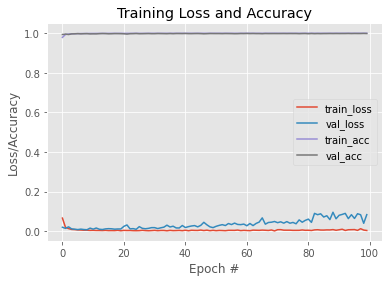

In [9]:
tf.keras.backend.clear_session()

# scale the data to [0,1]
sData = data.astype('float32')/255.0

# store labels as integers
sLabels = labels.astype('uint8')

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 10)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# ensure data is in the right shape
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

# build and compile a LeNet-5 model
model = LeNet.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")

# fit the model
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# print a model summary
print(model.summary())

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=5))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Dogs vs. Cats

Let's test these nets along with the preprocessor and data loader on the Dogs vs. Cats dataset from Kaggle (https://www.kaggle.com/c/dogs-vs-cats). This is a higher dimensional dataset than we have used in the past, with image sizes ranging from 50x50 to 500x500 in all different aspect ratios. We will simply distort them to be square images to see how it works.

This is a pretty challenging dataset because we have cats of all different colors and from different angles while the dogs come from many diffrent breeds, in different colors, and so on. CNNs are particularly well-suited to image recognition, so we will try a few modern CNN architectures with the dataset.

### 32x32 Experiment

First, let's load the images and resize them all to 32x32.

In [16]:
# load the images from a folder within the current working directory
print('[INFO] loading images...')

imagePaths = list(paths.list_images(os.getcwd() + '/dogs-vs-cats'))

# chose the size for the image
preprocessor = SimpleImagePreprocessor(32, 32)

# initialize the data loader
dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize])

# load the data into lists
(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


In [17]:
# save the labels as sLabels to avoid overwriting the data loader output below
sData = data
print(sData.shape)

sLabels = labels
print(sLabels.shape)

(25000, 32, 32, 3)
(25000,)


Let's encode the data and shrink the data values to be in [0,1].

In [18]:
# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

Let's run MiniVGGNet and see how it performs!

Model: "MiniVGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

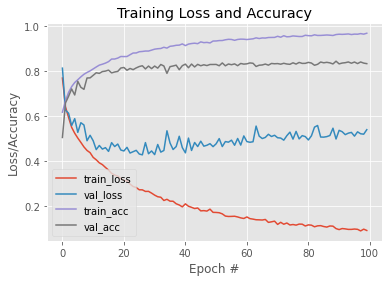

In [19]:
# clear GPU
tf.keras.backend.clear_session()

# build and compile the net
model = MiniVGGNet.build(32, 32, 3, 2)
opt = SGD(lr = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# print a summary of the model
print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is pretty good for a first try--we get 84% accuracy on the test set and the graph reveals the net seemed to converge pretty well but with some overfitting.

### 64x64 Experiment

Let's try the same approach with 64x64 images to see if the extra data helps.

In [20]:
# clear GPU
tf.keras.backend.clear_session()

print('[INFO] loading images...')
imagePaths = list(paths.list_images(os.getcwd() + '/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(64, 64)

dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


In [11]:
sLabels = labels

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(data, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

Let's try MiniVGGNet again, but with the Adam optimizer.

Model: "MiniVGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0

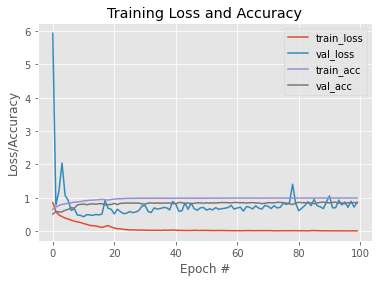

In [12]:
# clear GPU
tf.keras.backend.clear_session()

# build and compile the net
model = MiniVGGNet.build(64, 64, 3, 2)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# print a summary of the model
print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 256, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We see a slight improvement with 84% accuracy on the test set. We again see some noise in the training, but performance is pretty good.

### 227 x 227 Experiment 1 with AlexNet

Let's try it out with much larger images of size 227x227, which was used originally with AlexNet, but with the Adam optimizer.

In [7]:
print('[INFO] loading images...')
imagePaths = list(paths.list_images(os.getcwd() + '/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(227, 227)

dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


In [8]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

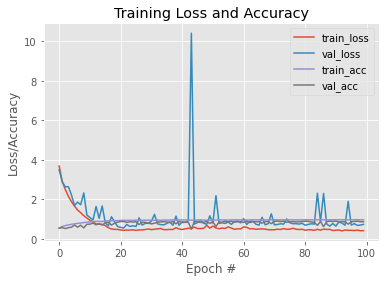

In [10]:
tf.keras.backend.clear_session()

model = AlexNet.build(227, 227, 3, 2)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### 227x227 Experiment 2 with AlexNet

This time, let's use SGD with momentum and Nesterov acceleration.

In [ ]:
print('[INFO] loading images...')
imagePaths = list(paths.list_images(os.getcwd() + '/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(227, 227)

dataLoader = SimpleImageDatasetLoader(0, preprocessors = [preprocessor.resize])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

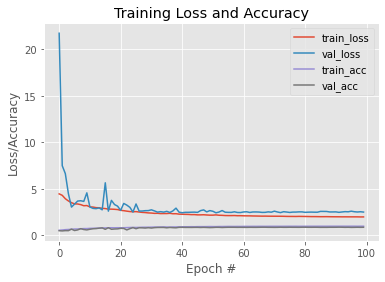

In [12]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

tf.keras.backend.clear_session()

model = AlexNet.build(227, 227, 3, 2)
opt = SGD(lr = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Here, we see a small improvement with 88% accuracy on the test set, 1% better performance with SGD than with Adam. This is similar to the approach Krizhevsky et. al. used in their ImageNet-winning work of 2012.

### 227x227 Experiment 3 with AlexNet (Random Cropping)

Another method used by Krishevsky et. al. was to resize all images to 256x256 and then randomly crop a 227x227 window from the image. Let's see if this helps right away as it might help us avoid some bias associated with the location of the animal in the frame. 

In [6]:
print('[INFO] loading images...')
imagePaths = list(paths.list_images(os.getcwd() + '/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(256, 256, 227, 227, 1)

dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize, preprocessor.randomCrop])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

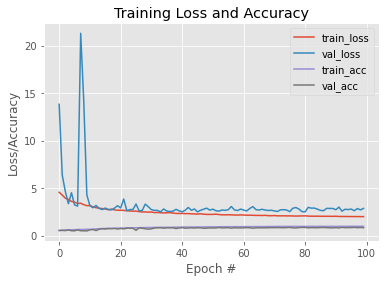

In [7]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

tf.keras.backend.clear_session()

model = AlexNet.build(227, 227, 3, 2)
opt = SGD(lr = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### 227x227 Experiment 4 with AlexNet (Random Cropping + Data Augmentation)

It seems random cropping did not really help, but perhaps we can use it to generate extra data by cropping several different windows of each image, which we may be able to exploit to get better performance on our test set.

In [7]:
print('[INFO] loading images...')
imagePaths = list(paths.list_images(os.getcwd() + '/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(256, 256, 227, 227, nAugment)

# crop 2 random windows from the image (more may be better if more RAM permitted it)
dataLoader = SimpleImageDatasetLoader(2, preprocessors = [preprocessor.resize, preprocessor.randomCrop])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


In [8]:
sData = data
print(sData.shape)

sLabels = labels
print(sLabels.shape)

(50000, 227, 227, 3)
(50000,)


In [9]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

print(trainX.shape)

(37500, 227, 227, 3)


Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

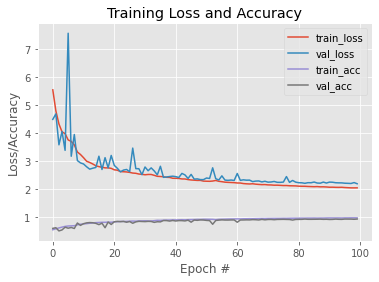

In [10]:
tf.keras.backend.clear_session()

model = AlexNet.build(227, 227, 3, 2)
opt = SGD(lr = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 64, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()